In [1]:
#| default_exp dataset

Dataset URL: https://datasetninja.com/dataset-of-annotated-food-crops-and-weed-images


# References:

- https://www.geeksforgeeks.org/machine-learning/random-forest-for-image-classification-using-opencv/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html - **stratification**
- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

In [2]:
#|export
from pathlib import Path
import os
import json
import IPython
import matplotlib.pyplot as plt
from skimage.feature import hog
from random import randint
from PIL import Image

from skimage import data, exposure

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

import numpy as np

# Dataset exploration

In [3]:
#|export
ds_dir = Path("../data")
ds_dir.absolute()

PosixPath('/home/master/dev/demokritos/ml_assignments/autofarm_assignment/notebooks/../data')

In [4]:
# Check uniformity in images
ann_ds = os.listdir(ds_dir / "ann")
import json
for each_f in ann_ds:
    with open(os.path.join(ds_dir, f"ann/{each_f}")) as f:
#         print(f"File: {os.path.join(ds_dir.absolute(), f'ann/{each_f}')}")
        d = str(json.load(f))
        if ("weed" in d) and ("crop" in d):
            raise Exception(f"Weed and Crop in => {each_f}") 

## Create image file list

In [5]:
#|export
def create_image_file_list(ds_dir):
    imgs_files = os.listdir(ds_dir.absolute() / "img")
    imgs_files_path = ds_dir / "img"

    imgs_ds = []
    for f in imgs_files:
        imgs_ds.append(os.path.join(ds_dir, f"img/{f}"))
    imgs_ds.sort()
    return imgs_ds

In [6]:
imgs_ds = create_image_file_list(ds_dir)
imgs_ds;

## Create labels file list

In [7]:
#|export
def create_labels_file_list(ds_dir):
    lbls_files = os.listdir(ds_dir.absolute() / "ann")
    lbls_files_path = ds_dir / "ann"

    lbls_ds = []
    for f in lbls_files:
        lbls_ds.append(os.path.join(ds_dir, f"ann/{f}"))
    lbls_ds.sort()
    return lbls_ds

In [8]:
lbls_ds = create_labels_file_list(ds_dir)
lbls_ds;

## Create dataset file, label list

In [9]:
#|export
def create_dataset_list(ds_dir=ds_dir):
    images_list = create_image_file_list(ds_dir)
    labels_list = create_labels_file_list(ds_dir)
    # Create dataset list[<img file>, <label>]
    ds = []
    for img, lbl in zip(images_list, labels_list):
        with open(lbl) as f:
            l = ""
            d = str(json.load(f))
            if "weed" in d:
                l = "weed"
            elif "crop" in d:
                l = "crop"
            ds.append([img, l])
    return ds

In [10]:
ds = create_dataset_list()
ds;

In [11]:
#|export
def print_ds_info(ds):
    # How many of each {weed, crop}
    nof_weeds = len([row[1] for row in ds if row[1] == "weed"])
    nof_crops = len([row[1] for row in ds if row[1] == "crop"])
    print(f"Nof weed samples: {nof_weeds}")
    print(f"Nof crop samples: {nof_crops}")

In [12]:
print_ds_info(ds)

Nof weed samples: 1116
Nof crop samples: 60


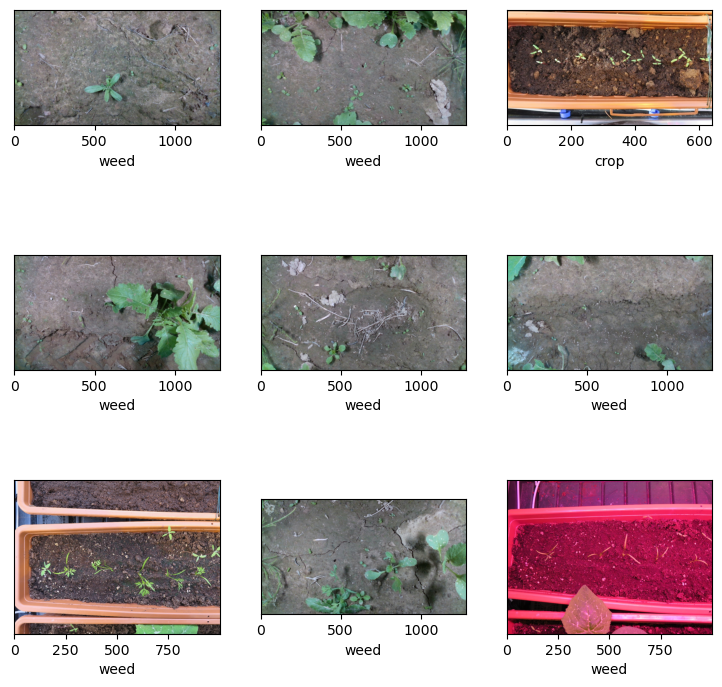

In [13]:
from skimage import io

nof_cols, nof_rows = 3, 3
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(nof_cols*3, nof_rows*3))

for ax in axes.flatten():
    ax.get_yaxis().set_ticks([])
    record = randint(0, len(ds))
    ax.set_xlabel(xlabel=ds[record][1])
    ax.imshow(io.imread(ds[record][0]))

### Notes:

**Dataset imbalance**: More weeds than crops.

**Minimum resolution**: Have to resize all images to match min resolution - uniformity.

**Empty samples**: Some images don't have any plants (greenery) in them, we need to remove those

## Get dataset resolution

In [14]:
#|export
from PIL import Image

def get_dataset_resolution_stats(ds):
    """
    Analyzes the dataset to find min, max, and average resolutions.
    """
    widths = []
    heights = []
    
    for each_img in ds:
        with Image.open(each_img[0]) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

    stats = {
        "min": (min(widths), min(heights)),
        "max": (max(widths), max(heights)),
        "avg": (sum(widths)//len(widths), sum(heights)//len(heights))
    }
    
    print(f"Stats: {stats}")
    return stats

In [15]:
get_dataset_resolution_stats(ds)

Stats: {'min': (360, 360), 'max': (1280, 1000), 'avg': (1177, 704)}


{'min': (360, 360), 'max': (1280, 1000), 'avg': (1177, 704)}

## Image loader

In [16]:
#|export
from skimage import io, img_as_float

def load_image(ds):
    """
    Loads images into memory and converts to float [0, 1] range.
    """
    
    imgs = []
    c = 0
    for record in ds:
        img_path = record[0]
        img = io.imread(img_path) # normalized range is 0-1
        imgs.append(img_as_float(img))
        
    return imgs

## Image resizing

In [22]:
#|export
from skimage.transform import resize

def resize_images(imgs, target_size=(256, 256)):
    """
    Standardizes a list of images to a uniform resolution.
    """
    
    resized_imgs = []
    for img in imgs:
        resized_imgs.append(resize(img, target_size, anti_aliasing=True))
    return resized_imgs

## Greenery filtering 

This is an aggressive function which filters images based on the hue channel.

In [24]:
#|export
from skimage.color import rgb2hsv
import numpy as np

def has_plant_matter(imgs, h_min=0.15, h_max=0.5, s_min=0.15, v_min=0.05):
    """
    Ultra-safe gatekeeper. 
    Returns True if any plant-like pixels are detected.
    This preserves rare classes (crops) even if they are very small in the frame.
    """
    valid_mask = []
    
    for img in imgs:
        hsv = rgb2hsv(img)
        h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
        
        # Multigated logic still filters 'non-plant' colors, 
        # but we no longer care about the SIZE of the plant.
        plant_mask = (h > h_min) & (h < h_max) & (s > s_min) & (v > v_min)
        
        # Keep if at least 1 pixel is found
        valid_mask.append(np.any(plant_mask))
            
    return np.array(valid_mask)

## Clean dataset

Apply the previous functions on the whole dataset.

In [27]:
#|export
def clean_dataset_pipeline(ds, target_size=(256, 256)):
    """
    Runs the full dataset preparation: Load -> Resize -> Filter.
    """
    # 1. Load labels (needed to keep them synced with images)
    y_raw = np.array([record[1] for record in ds])

    # 2. Load images into memory [0, 1] range
    print("Loading images...")
    X_raw = load_image(ds)
    
    # 3. Standardize dimensions
    print("Resizing images...")
    X_res = resize_images(X_raw, target_size=target_size)
    
    # 4. Apply the multigate filter
#     print("Filtering 'garbage' images...")
#     valid_indices = has_plant_matter(X_res)
    
    # 5. Extract the clean data
    # We convert to a standard numpy array here for feature extraction and modeling
#     X_clean = np.array(X_res)[valid_indices]
#     y_clean = y_raw[valid_indices]
    
    # 6. Capture all
    X_clean = np.array(X_res)
    y_clean = y_raw

    print(f"Done! Cleaned dataset contains {len(X_clean)} samples.")
    return X_clean, y_clean

In [28]:
%%time
## THis might crash your jupyter server
X_clean, y_clean = clean_dataset_pipeline(ds)

Loading images...
Resizing images...
Filtering 'garbage' images...
Done! Cleaned dataset contains 1176 samples.
CPU times: user 57.6 s, sys: 30.8 s, total: 1min 28s
Wall time: 2min 50s


In [29]:
len(X_clean), len(y_clean) 

(1176, 1176)

In [33]:
np.unique(y_clean, return_counts=True)

(array(['crop', 'weed'], dtype='<U4'), array([  60, 1116]))